<div dir="rtl">
    <font size="4"><b>پروژه پنجم (فاز اول) – پیاده سازی و آموزش شبکه های عصبی Feed Forward</b><br></font>
    هدف پروژه: در فاز اول پروژه پنجم به پیاده سازی شبکه های عصبی چند لایه  جهت طبقه بندی تصاویر می پردازیم.<br>
    مجموعه داده: در این تمرین با یک مجموعه داده KMnist شامل تصاویری در مقیاس 28*28 پیکسل بصورت grayscale و 7500 تصویر از 20 کاراکتر مختلف، معرف یک هجا در خط هیراگانا، کار خواهیم کرد.<br>
</div>

<div dir="rtl">
    <font size="4"><b>فاز اول: بررسی و پیش پردازش داده ها</b><br></font><br>
    گام 1: نمایش یک تصویر رندوم و بررسی محدوده هر پیکسل<br>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = np.genfromtxt('train_images.csv', delimiter=',')
train_label = np.genfromtxt('train_labels.csv', delimiter=',')
test_data = np.genfromtxt('test_images.csv', delimiter=',')
test_label = np.genfromtxt('test_labels.csv', delimiter=',')

In [3]:
train_data = np.delete(train_data, (0), 0)
train_data = np.delete(train_data, (0), 1)
train_label = np.delete(train_label, (0), 0)
train_label = np.delete(train_label, (0), 1)
test_data = np.delete(test_data, (0), 0)
test_data = np.delete(test_data, (0), 1)
test_label = np.delete(test_label, (0), 0)
test_label = np.delete(test_label, (0), 1)

In [4]:
train_label = train_label.reshape((-1, 1))
test_label = test_label.reshape((-1, 1))

In [5]:
train_data.max(), train_data.min()

(255.0, 0.0)

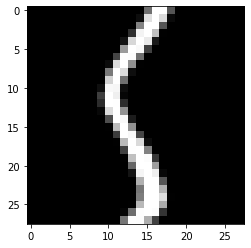

In [6]:
import random

rand_img = random.randrange(1, 60000, 1)
plt.figure()
plt.imshow(np.reshape(train_data[rand_img], (28,28)), cmap="gray")

<div dir="rtl">
    گام 2: نمایش یک تصویر از هر کلاس بهمراه نوع آن<br>
</div>

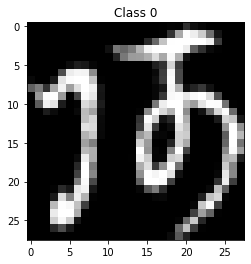

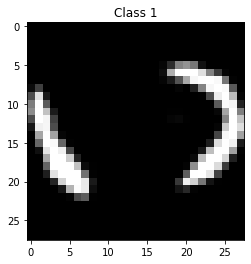

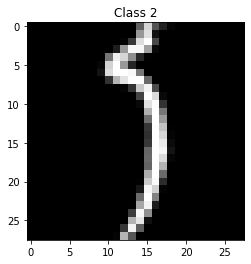

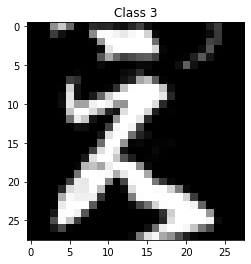

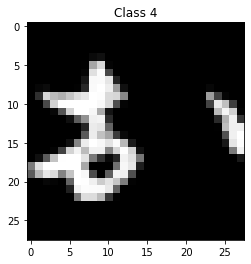

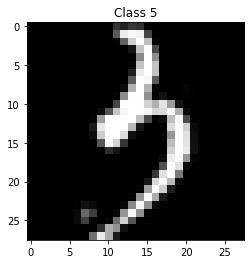

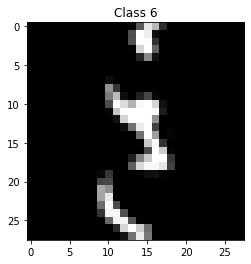

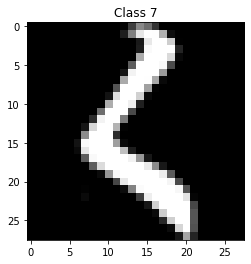

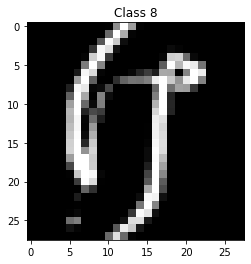

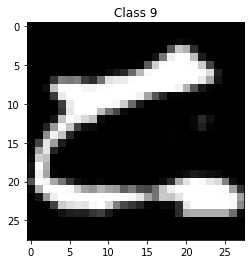

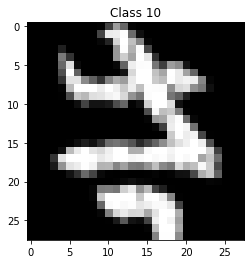

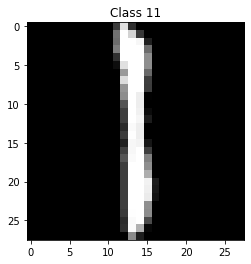

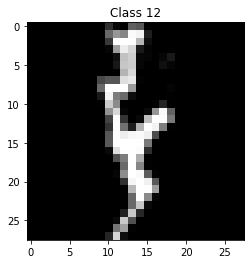

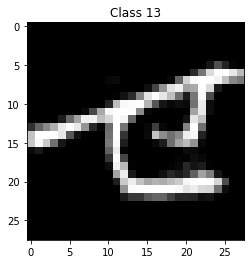

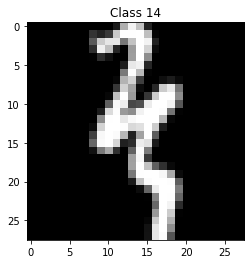

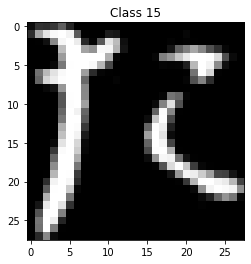

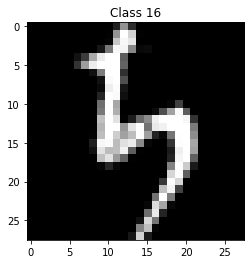

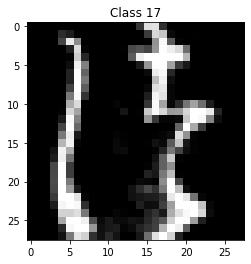

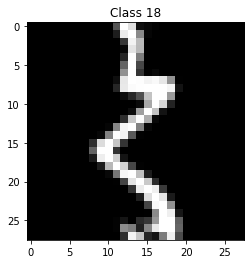

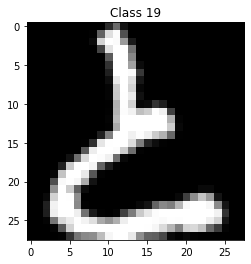

In [7]:
for i in range(20):
    plt.figure()
    plt.title("Class "+ str(i))
    plt.imshow(np.reshape(train_data[np.where(train_label == i)[0][0]], (28, 28)), cmap="gray")

<div dir="rtl">
    <br><br><br>
    گام 3: نمایش نمودار تعداد تصاوری هر دسته برای مجموعه test و train
</div>

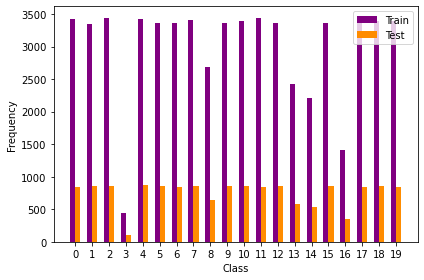

In [8]:
x = np.arange(20)
labels, train_label_count = np.unique(train_label, return_counts=True)
labels, test_label_count = np.unique(test_label, return_counts=True)

fig, ax = plt.subplots()
ax.bar(x - 0.15, train_label_count, color='purple', width=0.3, label='Train')
ax.bar(x + 0.15, test_label_count, color='darkorange', width=0.3, label='Test')
ax.set_ylabel('Frequency')
ax.set_xlabel('Class')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.show()

<div dir="rtl">
    گام 4: نرمالسازی داده ها<br>
    نرمال نکردن داده ها ممکن است موجب سرریز یا انفجار گرادیان شود که برای جلوگیری از این کار و همچنین یکی کردن scale داده ها آنها را نرمالایز میکنیم.
</div>

In [9]:
train_data = train_data / 255
test_data = test_data / 255

# Dataloader

In [11]:
import sklearn
from sklearn.utils import shuffle
import math

class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors = np.eye(n_classes)[labels.astype(int)]
        return onehot_vectors
    
    def __shuffle_dataset(self):
        self.__data, self.__onehot_labels = sklearn.utils.shuffle(self.__data, self.__onehot_labels)
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [28]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        relu_value = np.matrix(np.maximum(matrix, 0), dtype=float)
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.matrix(np.where(matrix > 0, 1, 0), dtype=float)
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leacky_relu_value = np.matrix(np.where(matrix > 0, matrix, matrix * self.negative_slope), dtype=float)
        return leacky_relu_value

    def derivative(self, matrix):
        leacky_relu_derivative = np.matrix(np.where(matrix > 0, 1, self.negative_slope), dtype=float)
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        sigmoid_value = 1/(1 + np.exp(-temp))
        return sigmoid_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        return np.multiply(self.__val(temp), (1 - self.__val(temp)))
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        sub_max = np.matrix(matrix - np.max(matrix, axis=1), dtype=float)
        numerator = np.exp(sub_max)
        denominator = np.sum(numerator, axis=1)
        softmax_value = numerator / denominator
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass

    def __val(self, matrix):
        tanh_value = np.matrix(matrix, dtype=float)
        tanh_value = np.tanh(tanh_value)
        return np.matrix(tanh_value)

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        temp = self.__val(temp)
        tanh_deravative = 1 - np.power(temp, 2)
        return tanh_deravative
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [13]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        sub_max = np.matrix(true_val - np.max(true_val, axis=1))
        numerator = np.exp(sub_max)
        denominator = np.sum(numerator, axis=1)
        softmax_value = numerator / denominator
        epsilon = 1e-12
        softmax_value = np.clip(softmax_value, epsilon, 1. - epsilon)
        N = softmax_value.shape[0]
        cross_entropy_value = -np.sum(np.multiply(np.matrix(expected_val), np.log(softmax_value + 1e-9))) / N
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        sub_max = np.matrix(true_val - np.max(true_val, axis=1))
        numerator = np.exp(sub_max)
        denominator = np.sum(numerator, axis=1)
        softmax_value = numerator / denominator
        cross_entropy_derivative = softmax_value - np.matrix(expected_val)
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

<div dir="rtl">
    بطور کلی پروسه یادگیری به دو گام forward و backpropagation تقسیم میشود.<br>
    برای گام backpropagation ما یک مقدار backprop tensor برای پاس دادن به لایه های قبل برای آپدیت وزن و بایاس محاسبه میکنیم.<br>
    روابط آپدیت وزنها داخل کد قابل مشاهده است.  برای آپدیت بایاس نیز کافی است فرض کنیم هر داده ی ورودی یک ویژگی با مقدار همواره 1 دارد. در این صورت می توان آپدیت بایاس را مشابه آپدیت وزن ها در نظر گرفت.
</div>

In [14]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        self.__last_input = np.matrix(layer_input, dtype=float)
        self.__last_activation_input = self.__last_input * self.__weight + self.__bias
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        backprop_tensor = np.matrix(backprop_tensor, dtype=float)
        dl_dy = np.multiply(backprop_tensor, self.__last_activation_derivative)
        temp = np.matrix(np.ones((np.size(backprop_tensor,0), 1)), dtype=float)
        delta_bias = np.matmul(np.transpose(temp), dl_dy)
        delta_weight = np.matmul(np.transpose(self.__last_input), dl_dy)
        backprop_tensor = np.matmul(dl_dy, np.transpose(self.__weight))
        self.__weight = self.__weight - lr * delta_weight
        self.__bias = self.__bias - lr * delta_bias
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.matrix(np.random.uniform(low, high, (dim1, dim2)), dtype=float)
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.matrix(np.random.normal(mean, np.sqrt(var), (dim1, dim2)), dtype=float)
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [15]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        network_output = network_input
        for layer in self.__layers_list:
            network_output = layer.forward(network_output)
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        out = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(out, y_batch)
        batch_average_loss = self.__loss(out, y_batch)
        self.__update_weights(out, y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        out = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(out, y_batch)
        batch_average_loss = self.__loss(out, y_batch)
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        labels = outputs.argmax(axis=1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        labels = self.__get_labels(output)
        expected_labels = self.__get_labels(expected_output)
        temp = labels - expected_labels
        accuracy = np.matrix(np.vectorize(lambda x: 1 if x == 0 else 0)(temp), dtype=float)
        return np.mean(accuracy)
    
    
    def __update_weights(self, output, y_train):
        backprop_tensor = self.__loss.derivative(output, y_train)
        for layer in reversed(self.__layers_list):
            backprop_tensor = layer.update_weights(backprop_tensor, self.__lr)
        return

# Training Sample Code

<div dir="rtl">
    <b>قسمت 1) آموزش شبکه</b>

</div>

In [16]:
train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5808069029850746	Average Loss: 1.4818015113182141
	Test: Average Accuracy: 0.6286347517730497	Average Loss: 1.3441443159688813
Epoch 2:
	Train: Average Accuracy: 0.7664079157782516	Average Loss: 0.8520024358548505
	Test: Average Accuracy: 0.6823803191489362	Average Loss: 1.1436969673744666
Epoch 3:
	Train: Average Accuracy: 0.8005063965884861	Average Loss: 0.735887973246308
	Test: Average Accuracy: 0.7043439716312055	Average Loss: 1.0728320692608293
Epoch 4:
	Train: Average Accuracy: 0.8176472547974414	Average Loss: 0.6669860137808604
	Test: Average Accuracy: 0.7227171985815604	Average Loss: 1.0082534788118893
Epoch 5:
	Train: Average Accuracy: 0.8305736940298507	Average Loss: 0.6164587345602992
	Test: Average Accuracy: 0.7345301418439716	Average Loss: 0.9704910668811074
Epoch 6:
	Train: Average Accuracy: 0.8410014658848614	Average Loss: 0.5781473042220916
	Test: Average Accuracy: 0.7438829787234043	Average Loss: 0.9483468268361771
Epoch 7:
	Train: 

<div dir="rtl">
    <b>قسمت 2) وزندهی شبکه</b><br>
    اگر مقدار اولیه تمام وزنهای شبکه را برابر صفر قرار بدهیم، مشاهده میشود که مقدار average loss بسیار زیاد و مقدار average accuracy بسیار کم خواهد شد.

</div>

<div dir="rtl">
    <b>قسمت 3) تاثیر learning rate</b><br>
    کاهش بیش از حد (کوچکی بیش از حد) learning rate باعث کند شدن فرایند آموزش میوشد و زمان میبرد تا به جواب درست برسیم.<br>
    افزایش بیش از حد (بزرگی بیش از حد) آن نیز موجب واگرایی و در نتیجه نرسیدن به وزن و بایاس درست در مدل میشود.
</div>

In [19]:
# bigger learning rate

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.01
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.05630330490405117	Average Loss: 2.9666918692576334
	Test: Average Accuracy: 0.05642730496453901	Average Loss: 2.9489122085641237
Epoch 2:
	Train: Average Accuracy: 0.11498867270788912	Average Loss: 2.746467451996932
	Test: Average Accuracy: 0.2168218085106383	Average Loss: 2.432256259203008
Epoch 3:
	Train: Average Accuracy: 0.40031982942430705	Average Loss: 1.9319713693619096
	Test: Average Accuracy: 0.4074468085106383	Average Loss: 1.9741748134038177
Epoch 4:
	Train: Average Accuracy: 0.5395455756929638	Average Loss: 1.5582221874625493
	Test: Average Accuracy: 0.4462101063829787	Average Loss: 1.8624579285335514
Epoch 5:
	Train: Average Accuracy: 0.5871701759061834	Average Loss: 1.421807177001625
	Test: Average Accuracy: 0.5264406028368794	Average Loss: 1.70843982521103
Epoch 6:
	Train: Average Accuracy: 0.6245002665245203	Average Loss: 1.3163194120729607
	Test: Average Accuracy: 0.5403147163120567	Average Loss: 1.661366423858363
Epoch 7:
	Train: A

In [22]:
# smaller learning rate

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.0001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Relu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.11487206823027718	Average Loss: 2.842191832257757
	Test: Average Accuracy: 0.20968528368794329	Average Loss: 2.6456209100331085
Epoch 2:
	Train: Average Accuracy: 0.40736607142857145	Average Loss: 2.232741936359742
	Test: Average Accuracy: 0.43060726950354616	Average Loss: 2.0806086544663347
Epoch 3:
	Train: Average Accuracy: 0.5788079690831557	Average Loss: 1.6155316844908962
	Test: Average Accuracy: 0.4961436170212766	Average Loss: 1.7404290377983684
Epoch 4:
	Train: Average Accuracy: 0.6392090884861408	Average Loss: 1.3157911778094196
	Test: Average Accuracy: 0.5401374113475178	Average Loss: 1.5778554623884056
Epoch 5:
	Train: Average Accuracy: 0.6766724413646056	Average Loss: 1.1707463508127016
	Test: Average Accuracy: 0.5715868794326242	Average Loss: 1.4907963959359956
Epoch 6:
	Train: Average Accuracy: 0.6998933901918977	Average Loss: 1.086730358382468
	Test: Average Accuracy: 0.5928634751773051	Average Loss: 1.4234805895545455
Epoch 7:
	Train

<div dir="rtl">
    <b>قسمت 4) تاثیر activation function</b><br><br>
    <b>LeakyRelu</b><br>
    برتری Leaky Relu بر Relu این است که در Relu مقادیر منفی با صفر جایگزین میشوند ولی در Leaky Relu این مقادیر با یک ضریب کوچکتر از 1 جایگزین میکنیم و این به معنی میباشد که تقریبا هیچ ویژگی را کنار نمیگذاریم.<br>
    همینطور در LeakyRelu چون مشتق برای مقادیر منفی صفر نخواهد بود احتمال بروز مشکل vanishing gradian وجود نخواهد داشت.
</div>

In [23]:
#LeakyRelu

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.584155117270789	Average Loss: 1.470524564040509
	Test: Average Accuracy: 0.6427748226950354	Average Loss: 1.284621210939934
Epoch 2:
	Train: Average Accuracy: 0.7684734808102346	Average Loss: 0.8524742468146036
	Test: Average Accuracy: 0.6789893617021276	Average Loss: 1.1742989726385347
Epoch 3:
	Train: Average Accuracy: 0.8014392324093816	Average Loss: 0.7357171183101928
	Test: Average Accuracy: 0.710017730496454	Average Loss: 1.055216052115961
Epoch 4:
	Train: Average Accuracy: 0.8209621535181236	Average Loss: 0.6624235958993735
	Test: Average Accuracy: 0.7329787234042553	Average Loss: 0.9965134211982891
Epoch 5:
	Train: Average Accuracy: 0.8326226012793176	Average Loss: 0.6089067846123644
	Test: Average Accuracy: 0.7412234042553192	Average Loss: 0.953660817582021
Epoch 6:
	Train: Average Accuracy: 0.8449327025586354	Average Loss: 0.5678388540281122
	Test: Average Accuracy: 0.7499335106382978	Average Loss: 0.9158088564040116
Epoch 7:
	Train: Avera

<div dir="rtl">
    <b>Sigmoid</b><br>
    تابع Sigmoid بدلیل وجود تابع exponential کندتر است و همینطور برای مقادیر خیلی بزرگ یا خیلی کوچک منفی بدلیل صفر شدن مشتق برخورد به مشکل vanishing gradian ممکن خواهد بود.
</div>

In [27]:
#Sigmoid

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Sigmoid(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.06576492537313433	Average Loss: 2.9460828809747013
	Test: Average Accuracy: 0.14350620567375885	Average Loss: 2.9035194600915677
Epoch 2:
	Train: Average Accuracy: 0.19366337953091683	Average Loss: 2.6705244789576175
	Test: Average Accuracy: 0.22992021276595745	Average Loss: 2.5141974290609728
Epoch 3:
	Train: Average Accuracy: 0.3719183102345416	Average Loss: 2.1466928382440895
	Test: Average Accuracy: 0.37544326241134746	Average Loss: 2.0671129760267872
Epoch 4:
	Train: Average Accuracy: 0.5495402452025586	Average Loss: 1.6555988701064592
	Test: Average Accuracy: 0.49621010638297874	Average Loss: 1.7508129034549529
Epoch 5:
	Train: Average Accuracy: 0.642407382729211	Average Loss: 1.333470792237615
	Test: Average Accuracy: 0.5529255319148936	Average Loss: 1.5580144619661564
Epoch 6:
	Train: Average Accuracy: 0.685534381663113	Average Loss: 1.152742186138612
	Test: Average Accuracy: 0.5904033687943263	Average Loss: 1.43534669439158
Epoch 7:
	Train:

<div dir="rtl">
    <b>Tanh</b><br>
    مشکل این روش نیز مشابه تابع Sigmoid میباشد.
</div>

In [29]:
#Tanh

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=64, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=64, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=Tanh(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.1295142590618337	Average Loss: 2.762531708371936
	Test: Average Accuracy: 0.24292996453900711	Average Loss: 2.3972355141143007
Epoch 2:
	Train: Average Accuracy: 0.44861074093816633	Average Loss: 1.8599794912958576
	Test: Average Accuracy: 0.4888962765957447	Average Loss: 1.749578277560141
Epoch 3:
	Train: Average Accuracy: 0.6454057835820896	Average Loss: 1.2915762932694448
	Test: Average Accuracy: 0.573515070921986	Average Loss: 1.5080858443278513
Epoch 4:
	Train: Average Accuracy: 0.7056236673773987	Average Loss: 1.0629201077630548
	Test: Average Accuracy: 0.6023492907801418	Average Loss: 1.3888264328596036
Epoch 5:
	Train: Average Accuracy: 0.73840618336887	Average Loss: 0.9448781981694425
	Test: Average Accuracy: 0.629543439716312	Average Loss: 1.3226003419277015
Epoch 6:
	Train: Average Accuracy: 0.7570295842217484	Average Loss: 0.8745554571834572
	Test: Average Accuracy: 0.644392730496454	Average Loss: 1.256919731092195
Epoch 7:
	Train: Avera

<div dir="rtl">
    <b>قسمت 5) تاثیر batch size</b><br><br>
    در batch sizeهای بزرگتر مدت زمانی که هر ایپاک دارد کمتر میشود در عین حال در تعداد ایپاک بیشتری به مدل مطلوب خواهیم رسید.<br>
    از طرف دیگر در batch sizeهای کوچکتر طول زمان برای هر ایپاک کوتاه تر خواهد شد در عین حال در تعداد ایپاک کمتری به مدل مطلوب خواهیم رسید.<br><br>
    علت استفاده از batch یا دسته این است که شبکه بجای بررسی تمامی داده ها یکجا آنها را دسته دسته مشاهده کرده و پس از مشاهده هر دسته وزن ها را آپدیت میکند نه بعد از مشاهده کل داده ها.
</div>

In [34]:
#batch_size = 16

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=16, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=16, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.57785	Average Loss: 1.4647004936189114
	Test: Average Accuracy: 0.6333955223880597	Average Loss: 1.3262851345148683
Epoch 2:
	Train: Average Accuracy: 0.7627166666666667	Average Loss: 0.8678124621155043
	Test: Average Accuracy: 0.6676439232409381	Average Loss: 1.187781583977446
Epoch 3:
	Train: Average Accuracy: 0.7932	Average Loss: 0.759101613807647
	Test: Average Accuracy: 0.6911647121535182	Average Loss: 1.113749787526819
Epoch 4:
	Train: Average Accuracy: 0.81	Average Loss: 0.6955277867949594
	Test: Average Accuracy: 0.7031583155650319	Average Loss: 1.0682751233376746
Epoch 5:
	Train: Average Accuracy: 0.8234666666666667	Average Loss: 0.6474294490458533
	Test: Average Accuracy: 0.7230143923240938	Average Loss: 1.0081688819519166
Epoch 6:
	Train: Average Accuracy: 0.8330166666666666	Average Loss: 0.6079185381809845
	Test: Average Accuracy: 0.7342084221748401	Average Loss: 0.96720641726335
Epoch 7:
	Train: Average Accuracy: 0.84285	Average Loss: 0

In [30]:
#batch_size = 32

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=32, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=32, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5785833333333333	Average Loss: 1.4707218663938277
	Test: Average Accuracy: 0.6341284648187633	Average Loss: 1.324775240879194
Epoch 2:
	Train: Average Accuracy: 0.7647666666666667	Average Loss: 0.856525854163206
	Test: Average Accuracy: 0.6818585643212509	Average Loss: 1.1508696409250962
Epoch 3:
	Train: Average Accuracy: 0.8001833333333334	Average Loss: 0.7363260892058032
	Test: Average Accuracy: 0.7063121890547264	Average Loss: 1.0758048454760751
Epoch 4:
	Train: Average Accuracy: 0.8202	Average Loss: 0.6624655237468872
	Test: Average Accuracy: 0.7218816631130064	Average Loss: 1.0150723903664969
Epoch 5:
	Train: Average Accuracy: 0.83375	Average Loss: 0.6099106106704125
	Test: Average Accuracy: 0.7354299928926795	Average Loss: 0.9711639348496391
Epoch 6:
	Train: Average Accuracy: 0.8432333333333333	Average Loss: 0.5737772899395388
	Test: Average Accuracy: 0.7435812011371713	Average Loss: 0.9412292297508632
Epoch 7:
	Train: Average Accuracy: 0.8490

In [32]:
#batch_size = 256

train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 20
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=256, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=256, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.5566932624113476	Average Loss: 1.6790742918100163
	Test: Average Accuracy: 0.6334571532114184	Average Loss: 1.2948902896800483
Epoch 2:
	Train: Average Accuracy: 0.774113475177305	Average Loss: 0.8091310307763573
	Test: Average Accuracy: 0.6889635370205174	Average Loss: 1.0922457213443708
Epoch 3:
	Train: Average Accuracy: 0.813142730496454	Average Loss: 0.6773490831167109
	Test: Average Accuracy: 0.7232103033006244	Average Loss: 0.9842574453260214
Epoch 4:
	Train: Average Accuracy: 0.8306571365248226	Average Loss: 0.6099432440408545
	Test: Average Accuracy: 0.7327616246654772	Average Loss: 0.954049270715391
Epoch 5:
	Train: Average Accuracy: 0.843362145390071	Average Loss: 0.5632508264949022
	Test: Average Accuracy: 0.7410828780107048	Average Loss: 0.9157463196792809
Epoch 6:
	Train: Average Accuracy: 0.8520279255319149	Average Loss: 0.530015379907215
	Test: Average Accuracy: 0.7536971732827833	Average Loss: 0.8751251149682228
Epoch 7:
	Train: Aver

<div dir="rtl">
    <b>قسمت 6) تاثیر epoch</b><br>
    استفاده از چندین epoch به منظور بهبود عملکرد شبکه است به این صورت که شبکه در هر epoch وزن ها آپدیت میکند تا به وزن مناسب برای مدل برسد.<br>
    افزایش تعداد epoch همواره مفید نخواهد بود و از یک مقداری به بعد موجب رخ دادن overfotting خواهد شد.<br>
    این overfitting روی نمودار ها نیز قابل مشاهده است و همینطور که دیده میشود از یک مقداری به بعد مقدار accuracy تغییری نخواهد کرد. همچنین برای loss مقدار آن بری epochهای بیشتر برای داده های train کم و کمتر میشود ولی برای test از یکجایی به بعد تاثیر عکس گذاشته و بیشتر میشود.
</div>

In [38]:
train_data_cp = np.copy(train_data)
train_label_cp = np.copy(train_label)
test_data_cp = np.copy(test_data)
test_label_cp = np.copy(test_label)

INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 200
TRAINLOADER = Dataloader(data=train_data_cp, labels=train_label_cp, n_classes=20, batch_size=256, shuffle=True)
TESTLOADER = Dataloader(data=test_data_cp, labels=test_label_cp, n_classes=20, batch_size=256, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(30, activation=LeakyRelu(), weight_initializer='normal')
network.add_layer(20, activation=Identical(), weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.4867796985815603	Average Loss: 1.8759196594169676
	Test: Average Accuracy: 0.609591045941124	Average Loss: 1.398189556064403
Epoch 2:
	Train: Average Accuracy: 0.7534020390070922	Average Loss: 0.8865646751506351
	Test: Average Accuracy: 0.6811092216770741	Average Loss: 1.1528356061372467
Epoch 3:
	Train: Average Accuracy: 0.7973348847517732	Average Loss: 0.7336658498595408
	Test: Average Accuracy: 0.7104078389830508	Average Loss: 1.0519940052586376
Epoch 4:
	Train: Average Accuracy: 0.8182457890070923	Average Loss: 0.6616139323181247
	Test: Average Accuracy: 0.7205829058876003	Average Loss: 1.01770895140009
Epoch 5:
	Train: Average Accuracy: 0.8312112145390071	Average Loss: 0.615335166296821
	Test: Average Accuracy: 0.727904075602141	Average Loss: 0.9835255772268263
Epoch 6:
	Train: Average Accuracy: 0.8374335106382979	Average Loss: 0.5816978922938958
	Test: Average Accuracy: 0.7408772859054417	Average Loss: 0.9443031178242063
Epoch 7:
	Train: Avera

	Train: Average Accuracy: 0.9112477836879433	Average Loss: 0.30813186729630404
	Test: Average Accuracy: 0.7849855040142729	Average Loss: 0.8573715227716281
Epoch 52:
	Train: Average Accuracy: 0.9119902482269503	Average Loss: 0.3069286699457536
	Test: Average Accuracy: 0.7769987734165923	Average Loss: 0.883024870015188
Epoch 53:
	Train: Average Accuracy: 0.9119015957446809	Average Loss: 0.30536042620778786
	Test: Average Accuracy: 0.7805321699375557	Average Loss: 0.8643980327635387
Epoch 54:
	Train: Average Accuracy: 0.9119791666666668	Average Loss: 0.3046206365043339
	Test: Average Accuracy: 0.7812709076717217	Average Loss: 0.8693873086129145
Epoch 55:
	Train: Average Accuracy: 0.9121287677304966	Average Loss: 0.30354201592365965
	Test: Average Accuracy: 0.7853827497769847	Average Loss: 0.8708094944653941
Epoch 56:
	Train: Average Accuracy: 0.9136580230496455	Average Loss: 0.3001150214170269
	Test: Average Accuracy: 0.7838669435771632	Average Loss: 0.8811136705877469
Epoch 57:
	Train: 

	Train: Average Accuracy: 0.923188164893617	Average Loss: 0.25864628618453034
	Test: Average Accuracy: 0.7736430921052632	Average Loss: 0.9864990911898553
Epoch 102:
	Train: Average Accuracy: 0.924362810283688	Average Loss: 0.25908090311118964
	Test: Average Accuracy: 0.769161881132917	Average Loss: 1.0213522306855518
Epoch 103:
	Train: Average Accuracy: 0.9228280141843971	Average Loss: 0.2590427675881986
	Test: Average Accuracy: 0.7723398472346119	Average Loss: 0.9991779083756882
Epoch 104:
	Train: Average Accuracy: 0.9229665336879433	Average Loss: 0.2587843298132148
	Test: Average Accuracy: 0.7728486005798394	Average Loss: 0.9975050703652799
Epoch 105:
	Train: Average Accuracy: 0.9246841755319148	Average Loss: 0.2558309636527146
	Test: Average Accuracy: 0.7729078389830508	Average Loss: 0.9928122598431718
Epoch 106:
	Train: Average Accuracy: 0.9242630762411348	Average Loss: 0.25621828596586055
	Test: Average Accuracy: 0.7692489964317574	Average Loss: 1.0251985307094722
Epoch 107:
	Tra

	Test: Average Accuracy: 0.7667331066012489	Average Loss: 1.0917703419867133
Epoch 151:
	Train: Average Accuracy: 0.9309341755319149	Average Loss: 0.2324148921003891
	Test: Average Accuracy: 0.7682245205173952	Average Loss: 1.1024318700859164
Epoch 152:
	Train: Average Accuracy: 0.9312056737588652	Average Loss: 0.23369786117177363
	Test: Average Accuracy: 0.7642485782783229	Average Loss: 1.1196806766087781
Epoch 153:
	Train: Average Accuracy: 0.9322584219858157	Average Loss: 0.23157698126119275
	Test: Average Accuracy: 0.7665170606601249	Average Loss: 1.1090930793862697
Epoch 154:
	Train: Average Accuracy: 0.9315159574468085	Average Loss: 0.23186802430556328
	Test: Average Accuracy: 0.7677087979482605	Average Loss: 1.10083293937008
Epoch 155:
	Train: Average Accuracy: 0.9314383865248226	Average Loss: 0.23077440656603715
	Test: Average Accuracy: 0.7693221732827833	Average Loss: 1.109995797614965
Epoch 156:
	Train: Average Accuracy: 0.9309674202127659	Average Loss: 0.23175861773399592
	T

	Train: Average Accuracy: 0.9372783687943264	Average Loss: 0.21310958232412364
	Test: Average Accuracy: 0.7583212533452274	Average Loss: 1.225485368487511


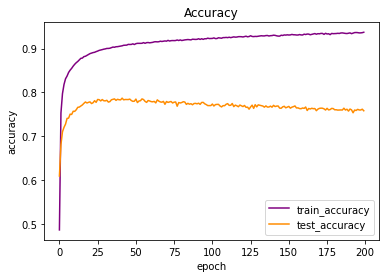

In [39]:
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(log["train_accuracy"], label="train_accuracy", color="purple")
plt.plot(log["test_accuracy"], label="test_accuracy", color="darkorange")
plt.legend(loc="best")
plt.show()

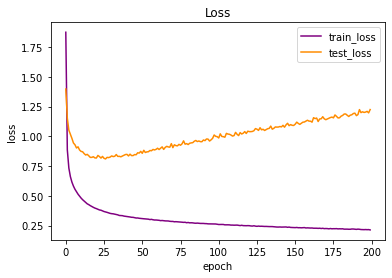

In [40]:
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(log["train_loss"], label="train_loss", color="purple")
plt.plot(log["test_loss"], label="test_loss", color="darkorange")
plt.legend(loc="best")
plt.show()